In [6]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("khalil-sabri01/PyTAGI_Experiments_MNIST")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [7]:
runs_df.head()

,summary,config,name
0,"{'_runtime': 322.2011806964874, '_step': 21, '...","{'model': 'FNN', 'sigma_v': 0, 'framework': 't...",torch_FNN_layers5_neurons512_batch16_lr0.001
1,"{'_runtime': 244.1311764717102, '_step': 25, '...","{'model': 'FNN', 'sigma_v': 0, 'framework': 't...",torch_FNN_layers5_neurons512_batch512_lr0.001
2,"{'_runtime': 209.12617802619937, '_step': 14, ...","{'model': 'FNN', 'sigma_v': 0, 'framework': 't...",torch_FNN_layers5_neurons32_batch16_lr0.001
3,"{'_runtime': 245.8845374584198, '_step': 25, '...","{'model': 'FNN', 'sigma_v': 0, 'framework': 't...",torch_FNN_layers5_neurons32_batch512_lr0.001
4,"{'_runtime': 288.2369954586029, '_step': 20, '...","{'model': 'FNN', 'sigma_v': 0, 'framework': 't...",torch_FNN_layers3_neurons512_batch16_lr0.001


In [9]:
# Flatten the nested 'summary' and 'config' columns
summary_df = pd.json_normalize(runs_df['summary'])
config_df = pd.json_normalize(runs_df['config'])

# Combine extracted data with original DataFrame
runs_cleaned_df = pd.concat([runs_df.drop(columns=['summary', 'config']), summary_df, config_df], axis=1)


In [10]:
runs_cleaned_df

,name,_runtime,_step,_timestamp,epoch,test_error_rate,training_error_rate,_wandb.runtime,model,sigma_v,framework,batch_size,num_epochs,num_layers,learning_rate,neurons_per_layer,channels_per_layer
0,torch_FNN_layers5_neurons512_batch16_lr0.001,322.201181,21,1.733542e+09,22,11.850000,14.625000,321,FNN,0.0,torch,16,40,5,0.001,512,0
1,torch_FNN_layers5_neurons512_batch512_lr0.001,244.131176,25,1.733541e+09,26,2.900000,1.365885,243,FNN,0.0,torch,512,40,5,0.001,512,0
2,torch_FNN_layers5_neurons32_batch16_lr0.001,209.126178,14,1.733541e+09,15,8.500000,10.437500,208,FNN,0.0,torch,16,40,5,0.001,32,0
3,torch_FNN_layers5_neurons32_batch512_lr0.001,245.884537,25,1.733541e+09,26,3.160000,1.580729,245,FNN,0.0,torch,512,40,5,0.001,32,0
4,torch_FNN_layers3_neurons512_batch16_lr0.001,288.236995,20,1.733541e+09,21,7.890000,6.937500,287,FNN,0.0,torch,16,40,3,0.001,512,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,tagi_CNN_layers1_channels8_batch16_sigma0_lr0.001,355.377028,39,1.733443e+09,40,2.990000,1.812500,355,CNN,0.0,tagi,16,40,1,0.001,0,8
176,tagi_CNN_layers1_channels8_batch512_sigma1.0_l...,342.187461,39,1.733443e+09,40,1.499311,0.742839,342,CNN,1.0,tagi,512,40,1,0.001,0,8
177,tagi_CNN_layers1_channels8_batch512_sigma0.5_l...,330.678239,39,1.733443e+09,40,1.626264,0.894531,330,CNN,0.5,tagi,512,40,1,0.001,0,8
178,tagi_CNN_layers1_channels8_batch512_sigma0.1_l...,340.973585,39,1.733442e+09,40,2.024357,1.451172,340,CNN,0.1,tagi,512,40,1,0.001,0,8


### 0. General performance per framework

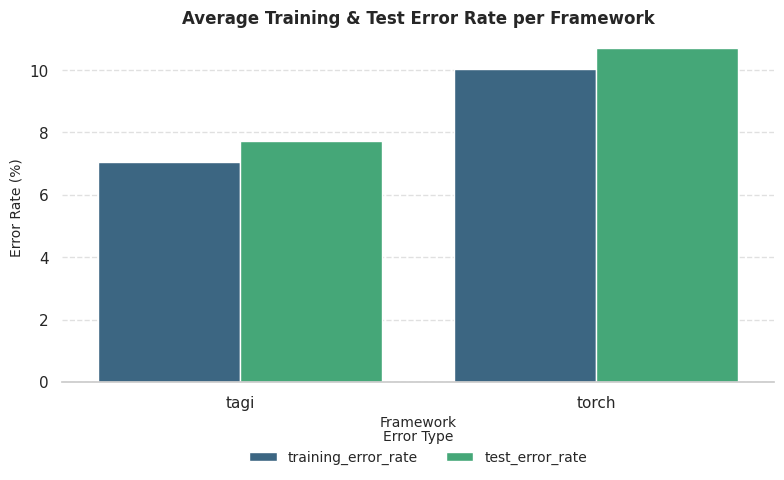

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_theme(style="whitegrid")

# Create a simple bar plot showing average error rates per framework
avg_error_df = runs_cleaned_df.groupby('framework')[['training_error_rate', 'test_error_rate']].mean()

# Plot settings
plt.figure(figsize=(8, 5))
sns.barplot(
    data=avg_error_df.reset_index().melt(id_vars='framework', var_name='Error Type', value_name='Error Rate'),
    x='framework',
    y='Error Rate',
    hue='Error Type',
    palette='viridis'
)

# Clip the y-axis to prevent negative values
plt.ylim(bottom=0)

# Enhance plot aesthetics
plt.title("Average Training & Test Error Rate per Framework", fontsize=12, fontweight='semibold')
plt.xlabel("Framework", fontsize=10)
plt.ylabel("Error Rate (%)", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust legend placement
plt.legend(
    title="Error Type",
    fontsize=10,
    title_fontsize=10,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),  # Positioned below the plot
    ncol=2,  # Arrange legend items horizontally
    frameon=False  # Remove legend box
)

# Remove unnecessary spines for cleaner look
sns.despine(left=True)

# Apply tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [64]:
# Overall average training and test error per framework
overall_df = runs_cleaned_df.groupby('framework', as_index=False).agg({
    'training_error_rate':'mean',
    'test_error_rate':'mean'
})
print("Overall Performance:")
print(overall_df)


Overall Performance:
  framework  training_error_rate  test_error_rate
0      tagi             7.065701         7.726400
1     torch            10.047924        10.694444


### 1. Batch Size Impact per Framework

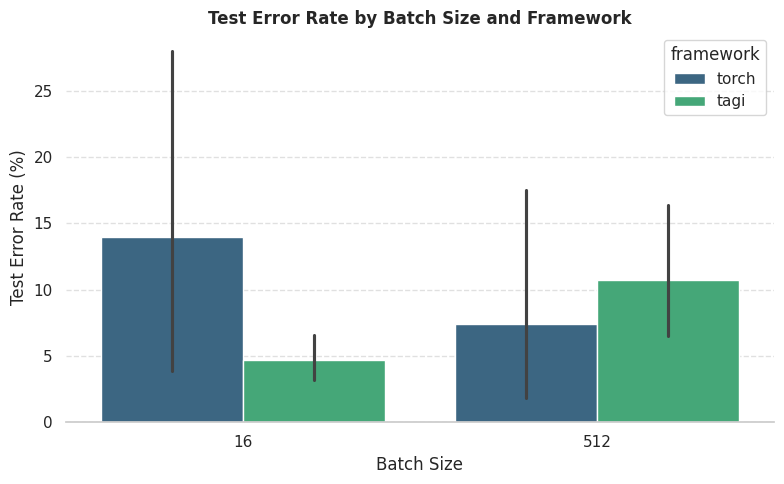

In [35]:
import numpy as np

# Plot test error vs. batch size for each framework
plt.figure(figsize=(8, 5))
sns.barplot(
    data=runs_cleaned_df,
    x='batch_size',
    y='test_error_rate',
    hue='framework',
    palette='viridis'  # Updated to handle future deprecation
)

# Clip the y-axis to prevent negative values
plt.ylim(bottom=0)

# Enhance plot aesthetics
plt.title("Test Error Rate by Batch Size and Framework", fontsize=12, fontweight='semibold')
plt.xlabel("Batch Size")
plt.ylabel("Test Error Rate (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)
plt.tight_layout()

# Show the plot
plt.show()


In [65]:
# Mean test error by batch size and framework, possibly averaged over models or separated by model
batch_sizes_of_interest = [16, 512]

batch_size_df = runs_cleaned_df[runs_cleaned_df['batch_size'].isin(batch_sizes_of_interest)]
batch_size_agg = batch_size_df.groupby(['framework','model','batch_size'], as_index=False)['test_error_rate'].mean()
print("Batch Size Impact:")
print(batch_size_agg)

# Example pivot if you want columns by batch_size
batch_size_pivot = batch_size_agg.pivot(index=['framework','model'], columns='batch_size', values='test_error_rate').reset_index()
print(batch_size_pivot)


Batch Size Impact:
   framework         model  batch_size  test_error_rate
0       tagi           CNN          16         1.736667
1       tagi           CNN         512        15.988243
2       tagi  CNNBatchNorm          16         1.965417
3       tagi  CNNBatchNorm         512         4.108480
4       tagi           FNN          16        10.420417
5       tagi           FNN         512        12.139175
6      torch           CNN          16        31.198333
7      torch           CNN         512        16.216667
8      torch  CNNBatchNorm          16         1.351667
9      torch  CNNBatchNorm         512         1.056667
10     torch           FNN          16         9.310000
11     torch           FNN         512         5.033333
batch_size framework         model         16        512
0               tagi           CNN   1.736667  15.988243
1               tagi  CNNBatchNorm   1.965417   4.108480
2               tagi           FNN  10.420417  12.139175
3              torch     

### 2. Number of Layers Impact per Framework

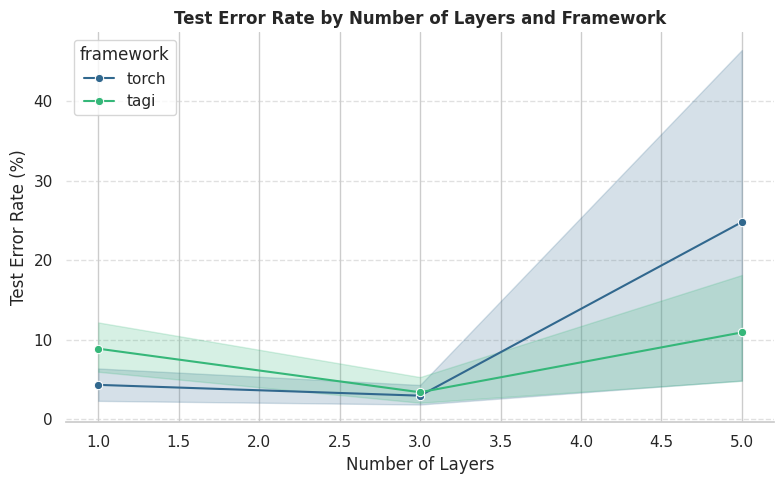

In [61]:
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=runs_cleaned_df,
    x='num_layers',
    y='test_error_rate',
    hue='framework',
    marker='o',
    palette='viridis'
)
plt.title("Test Error Rate by Number of Layers and Framework", fontsize=12, fontweight='semibold')
plt.xlabel("Number of Layers")
plt.ylabel("Test Error Rate (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig("num_layers_test_error.png", dpi=300)

plt.show()


In [66]:
layers_agg = runs_cleaned_df.groupby(['framework','num_layers'], as_index=False)['test_error_rate'].mean()
print("Test Error by Number of Layers:")
print(layers_agg)

Test Error by Number of Layers:
  framework  num_layers  test_error_rate
0      tagi           1         8.871603
1      tagi           3         3.388146
2      tagi           5        10.919449
3     torch           1         4.319167
4     torch           3         2.959167
5     torch           5        24.805000


In [67]:
runs_cleaned_df['runtime_minutes'] = runs_cleaned_df['_wandb.runtime'] / 60

time_agg = runs_cleaned_df.groupby(['framework','num_layers'], as_index=False).agg({
    'runtime_minutes':'mean',
    'test_error_rate':'mean'
})
print("Training Time and Test Error by Number of Layers:")
print(time_agg)

Training Time and Test Error by Number of Layers:
  framework  num_layers  runtime_minutes  test_error_rate
0      tagi           1         5.703125         8.871603
1      tagi           3         6.629167         3.388146
2      tagi           5        16.424653        10.919449
3     torch           1         4.498611         4.319167
4     torch           3         5.633333         2.959167
5     torch           5         5.194444        24.805000


###  4. Sigma Impact on TAGI (Line Plot Against Sigma)


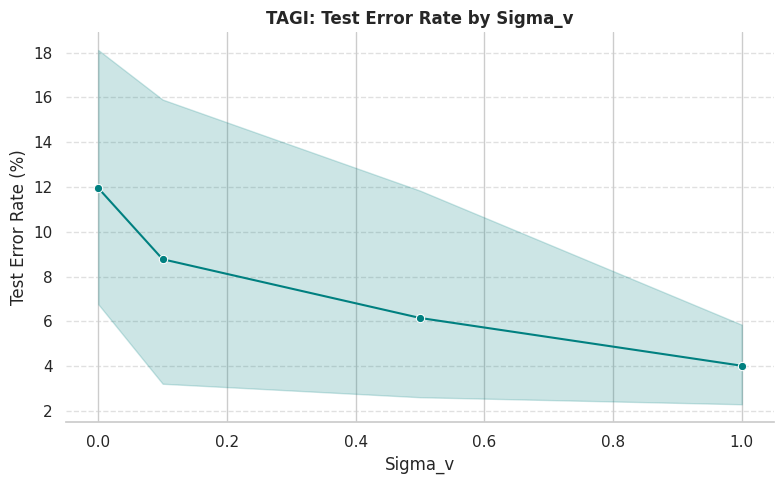

In [26]:
plt.figure(figsize=(8,5))
t = runs_cleaned_df[runs_cleaned_df['framework'] == 'tagi']
sns.lineplot(
    data=t,
    x='sigma_v',
    y='test_error_rate',
    marker='o',
    color='teal'
)
plt.title("TAGI: Test Error Rate by Sigma_v", fontsize=12, fontweight='semibold')
plt.xlabel("Sigma_v")
plt.ylabel("Test Error Rate (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)
plt.tight_layout()
plt.show()


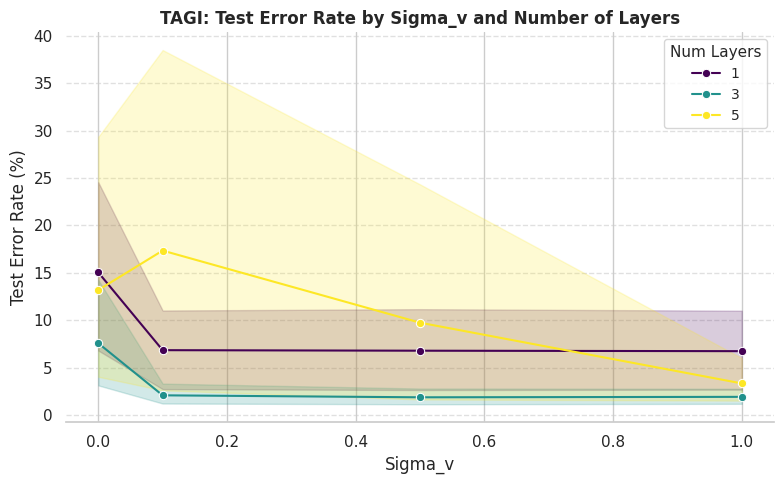

In [62]:
# Filter data for TAGI framework
t = runs_cleaned_df[runs_cleaned_df['framework'] == 'tagi']

# Create a line plot with sigma_v and num_layers
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=t,
    x='sigma_v',
    y='test_error_rate',
    hue='num_layers',  # Different lines for each number of layers
    marker='o',
    palette='viridis'
)

# Enhance plot aesthetics
plt.title("TAGI: Test Error Rate by Sigma_v and Number of Layers", fontsize=12, fontweight='semibold')
plt.xlabel("Sigma_v")
plt.ylabel("Test Error Rate (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)
plt.legend(title="Num Layers", fontsize=10, title_fontsize=11)
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig("tagi_sigma_comparison.png", dpi=300)

# Show the plot
plt.show()

### 5. Heatmap (Batch Size vs. Layers)

#### 5.1 Torch

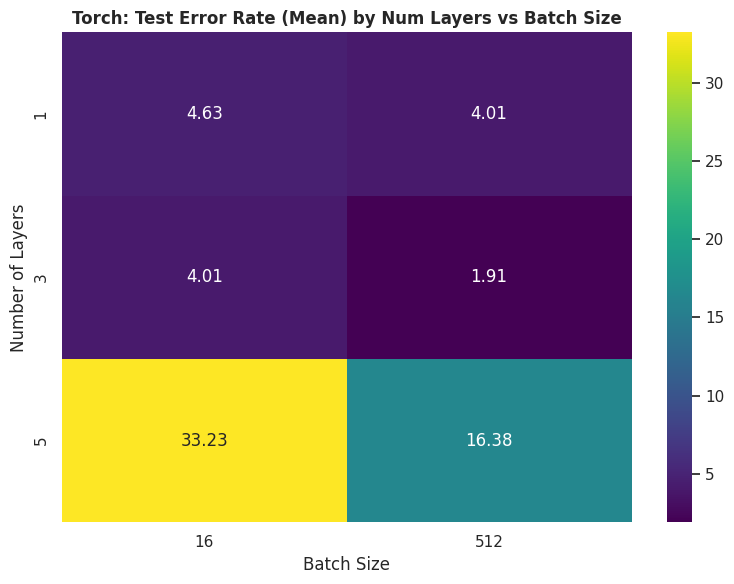

In [27]:
import numpy as np

# Pivot table for test error rate: rows=layers, columns=batch_size
pivot_torch = runs_cleaned_df[runs_cleaned_df.framework == 'torch'].pivot_table(
    index='num_layers',
    columns='batch_size',
    values='test_error_rate', aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_torch, annot=True, fmt=".2f", cmap="viridis")
plt.title("Torch: Test Error Rate (Mean) by Num Layers vs Batch Size", fontsize=12, fontweight='semibold')
plt.xlabel("Batch Size")
plt.ylabel("Number of Layers")
plt.tight_layout()
plt.show()


#### 5.2 TAGI

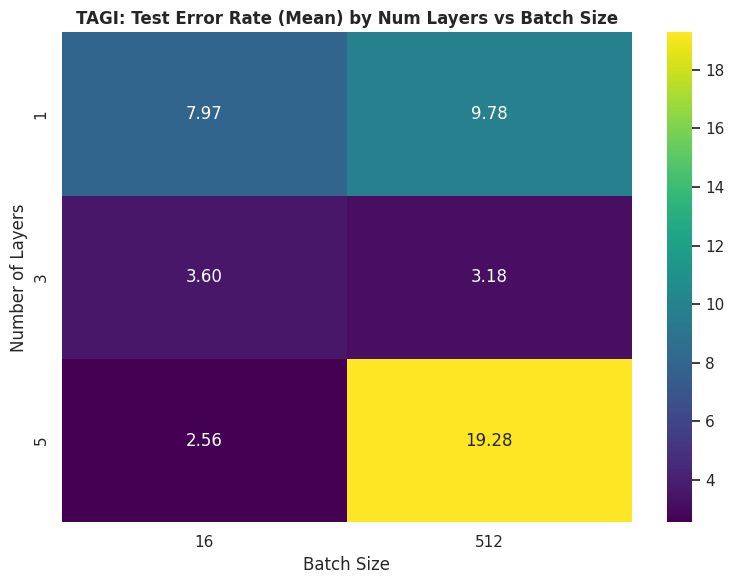

In [30]:
import numpy as np

# Pivot table for test error rate: rows=layers, columns=batch_size
pivot_torch = runs_cleaned_df[runs_cleaned_df.framework == 'tagi'].pivot_table(
    index='num_layers',
    columns='batch_size',
    values='test_error_rate', aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_torch, annot=True, fmt=".2f", cmap="viridis")
plt.title("TAGI: Test Error Rate (Mean) by Num Layers vs Batch Size", fontsize=12, fontweight='semibold')
plt.xlabel("Batch Size")
plt.ylabel("Number of Layers")
plt.tight_layout()
plt.show()


### 6. Facet Grid by Model Type


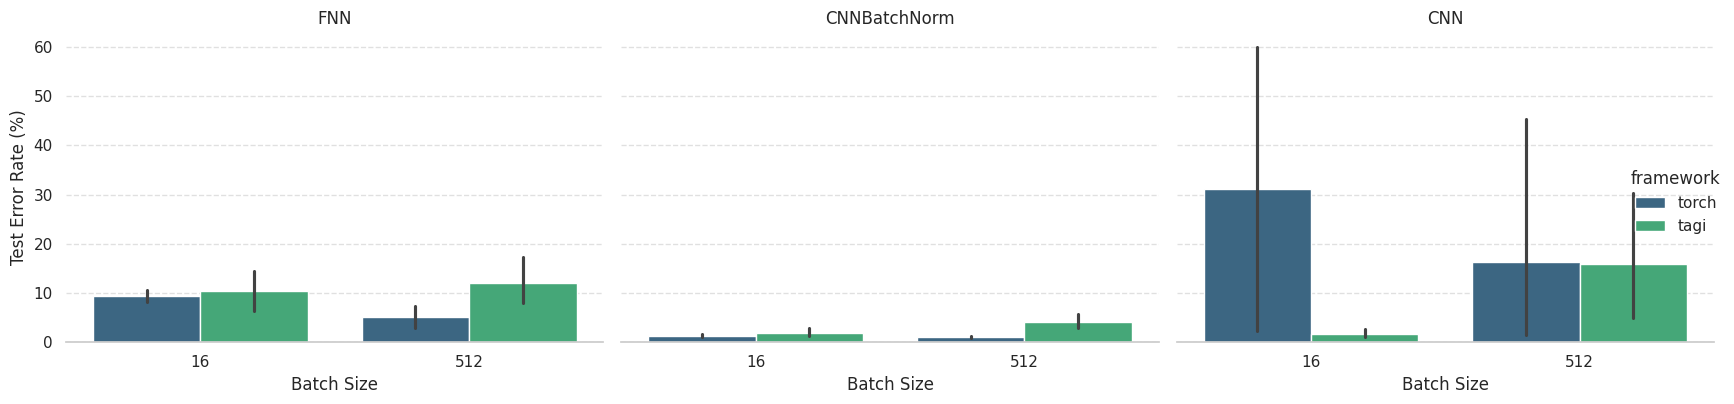

In [53]:
g = sns.catplot(
    data=runs_cleaned_df,
    x="batch_size",
    y="test_error_rate",
    hue="framework",
    col="model",
    kind="bar",
    palette='viridis',
    col_wrap=None,  # Ensure all facets are in one row
    height=4.2,
    aspect=1.3
)

g.set_titles("{col_name}")
g.set_axis_labels("Batch Size", "Test Error Rate (%)")
for ax in g.axes.ravel():
    ax.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)
plt.tight_layout()
plt.show()


### 7. TRaining time

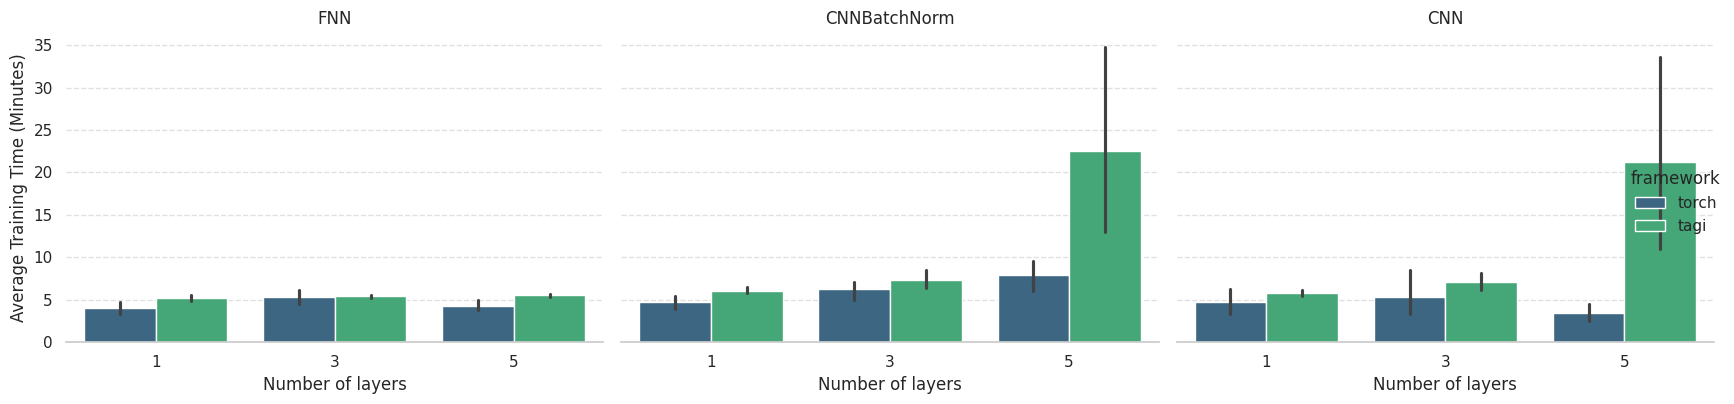

In [57]:
# Add a column for runtime in minutes
runs_cleaned_df['runtime_minutes'] = runs_cleaned_df['_wandb.runtime'] / 60

# Create the FacetGrid for average training time
g = sns.catplot(
    data=runs_cleaned_df,
    x="num_layers",
    y="runtime_minutes",
    hue="framework",
    col="model",
    kind="bar",
    palette='viridis',
    col_wrap=None,  # Ensure all facets are in one row
    height=4.2,
    aspect=1.3
)

# Set titles and axis labels
g.set_titles("{col_name}")
g.set_axis_labels("Number of layers", "Average Training Time (Minutes)")

# Add grid lines
for ax in g.axes.ravel():
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Remove unnecessary spines
sns.despine(left=True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### 8. Impact of number of neurons

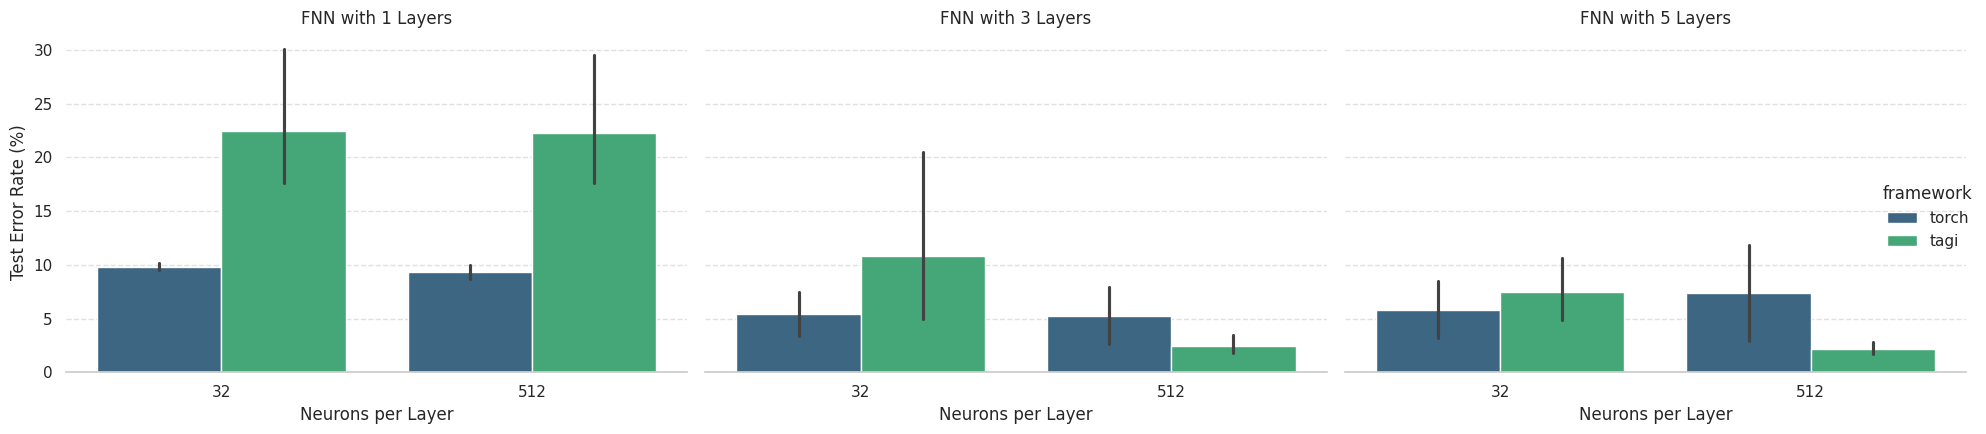

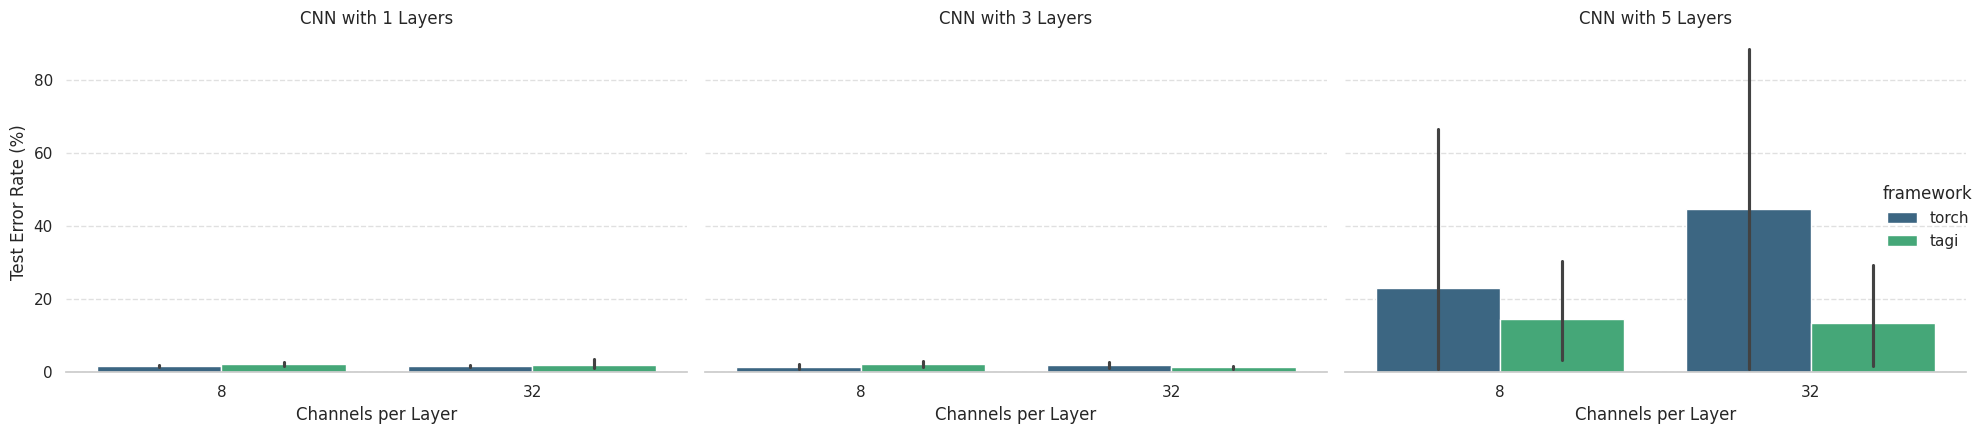

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Split the data into FNN and CNN subsets
fnn_data = runs_cleaned_df[runs_cleaned_df['model'] == 'FNN']
cnn_data = runs_cleaned_df[runs_cleaned_df['model'].str.contains('CNN')]

# FNN Plot: Neurons per Layer vs Test Error
g_fnn = sns.catplot(
    data=fnn_data,
    x="neurons_per_layer",
    y="test_error_rate",
    hue="framework",
    col="num_layers",
    kind="bar",
    palette="viridis",
    height=4.5,
    aspect=1.4
)

g_fnn.set_titles("FNN with {col_name} Layers")
g_fnn.set_axis_labels("Neurons per Layer", "Test Error Rate (%)")
for ax in g_fnn.axes.ravel():
    ax.grid(axis="y", linestyle="--", alpha=0.6)
sns.despine(left=True)
plt.tight_layout()

# Show the FNN plot
plt.show()

# CNN Plot: Channels per Layer vs Test Error
g_cnn = sns.catplot(
    data=cnn_data,
    x="channels_per_layer",
    y="test_error_rate",
    hue="framework",
    col="num_layers",
    kind="bar",
    palette="viridis",
    height=4.5,
    aspect=1.4
)

g_cnn.set_titles("CNN with {col_name} Layers")
g_cnn.set_axis_labels("Channels per Layer", "Test Error Rate (%)")
for ax in g_cnn.axes.ravel():
    ax.grid(axis="y", linestyle="--", alpha=0.6)
sns.despine(left=True)
plt.tight_layout()

# Show the CNN plot
plt.show()


In [75]:
fnn_df = runs_cleaned_df[(runs_cleaned_df['model']=='FNN') & (runs_cleaned_df['neurons_per_layer'].isin([32,512]))]
fnn_agg = fnn_df.groupby(['framework','num_layers','neurons_per_layer'], as_index=False)['test_error_rate'].mean()
print("FNN Test Error by Neurons per Layer:")
print(fnn_agg)

# If you want a pivoted view:
fnn_pivot = fnn_agg.pivot(index=['framework','num_layers'], columns='neurons_per_layer', values='test_error_rate').reset_index()
fnn_pivot


FNN Test Error by Neurons per Layer:
   framework  num_layers  neurons_per_layer  test_error_rate
0       tagi           1                 32        22.442175
1       tagi           1                512        22.288706
2       tagi           3                 32        10.855689
3       tagi           3                512         2.467575
4       tagi           5                 32         7.440679
5       tagi           5                512         2.183949
6      torch           1                 32         9.830000
7      torch           1                512         9.305000
8      torch           3                 32         5.425000
9      torch           3                512         5.265000
10     torch           5                 32         5.830000
11     torch           5                512         7.375000


neurons_per_layer,framework,num_layers,32,512
0,tagi,1,22.442175,22.288706
1,tagi,3,10.855689,2.467575
2,tagi,5,7.440679,2.183949
3,torch,1,9.830000,9.305000
4,torch,3,5.425000,5.265000
5,torch,5,5.830000,7.375000


In [74]:
cnn_df = runs_cleaned_df[(runs_cleaned_df['model'].str.contains('CNN')) & (runs_cleaned_df['channels_per_layer'].isin([8,32]))]
cnn_agg = cnn_df.groupby(['framework','num_layers','channels_per_layer'], as_index=False)['test_error_rate'].mean()
print("CNN Test Error by Channels per Layer:")
print(cnn_agg)

# Pivot if needed:
cnn_pivot = cnn_agg.pivot(index=['framework','num_layers'], columns='channels_per_layer', values='test_error_rate').reset_index()
cnn_pivot


CNN Test Error by Channels per Layer:
   framework  num_layers  channels_per_layer  test_error_rate
0       tagi           1                   8         2.151386
1       tagi           1                  32         2.097983
2       tagi           3                   8         2.180912
3       tagi           3                  32         1.321895
4       tagi           5                   8        14.530758
5       tagi           5                  32        13.415275
6      torch           1                   8         1.712500
7      torch           1                  32         1.677500
8      torch           3                   8         1.567500
9      torch           3                  32         1.965000
10     torch           5                   8        23.075000
11     torch           5                  32        44.737500


channels_per_layer,framework,num_layers,8,32
0,tagi,1,2.151386,2.097983
1,tagi,3,2.180912,1.321895
2,tagi,5,14.530758,13.415275
3,torch,1,1.712500,1.677500
4,torch,3,1.567500,1.965000
5,torch,5,23.075000,44.737500


In [73]:
fnn_df = runs_cleaned_df[(runs_cleaned_df['model']=='FNN') & (runs_cleaned_df['neurons_per_layer'].isin([32,512]))]
fnn_agg = fnn_df.groupby(['framework','neurons_per_layer'], as_index=False)['test_error_rate'].mean()
print("FNN Test Error by Neurons:")
print(fnn_agg)

# If you want a pivoted view:
fnn_pivot = fnn_agg.pivot(index=['framework'], columns='neurons_per_layer', values='test_error_rate').reset_index()
fnn_pivot


FNN Test Error by Neurons:
  framework  neurons_per_layer  test_error_rate
0      tagi                 32        13.579514
1      tagi                512         8.980077
2     torch                 32         7.028333
3     torch                512         7.315000


neurons_per_layer,framework,32,512
0,tagi,13.579514,8.980077
1,torch,7.028333,7.315000


In [71]:
cnn_df = runs_cleaned_df[(runs_cleaned_df['model'].str.contains('CNN')) & (runs_cleaned_df['channels_per_layer'].isin([8,32]))]
cnn_agg = cnn_df.groupby(['framework','channels_per_layer'], as_index=False)['test_error_rate'].mean()
print("CNN Test Error by Channels per Layer:")
print(cnn_agg)

# Pivot if needed:
cnn_pivot = cnn_agg.pivot(index=['framework'], columns='channels_per_layer', values='test_error_rate').reset_index()
print(cnn_pivot)


CNN Test Error by Channels per Layer:
  framework  channels_per_layer  test_error_rate
0      tagi                   8         6.287685
1      tagi                  32         5.611718
2     torch                   8         8.785000
3     torch                  32        16.126667
channels_per_layer framework         8         32
0                       tagi  6.287685   5.611718
1                      torch  8.785000  16.126667


In [72]:
cnn_pivot

channels_per_layer,framework,8,32
0,tagi,6.287685,5.611718
1,torch,8.785000,16.126667
